In [1]:
import os
import shutil
from PIL import Image
import random
import math
import tensorflow as tf
import pathlib
from tqdm import tqdm
from matplotlib import pyplot as plt

2023-07-28 23:07:42.699341: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
FROM_IMAGE_PATH = "preprocessedDataset/from/"
TO_IMAGE_PATH = "preprocessedDataset/to/" 
TRAIN_PATH = "dataset/train/"
TEST_PATH = "dataset/test/"
SPLIT_SIZE_IMAGE = 256  
DATASET_TRAIN_PERCENT = 0.8  
PREPARE_DATASET = False
BATCH_SIZE = 1
BUFFER_SIZE = 400
LAMBDA = 100

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
if not os.path.isdir("AerialImageDataset"):
    !curl -k https://files.inria.fr/aerialimagelabeling/getAerial.sh | bash
    shutil.rmtree("AerialImageDataset/test")

In [4]:

def split_image(original_image_path, output_folder, split_size):
    original_image = Image.open(original_image_path)
    width, height = original_image.size

    width = width - (width % split_size)
    height = height - (height % split_size)

    image_number = 0
    name, extension = os.path.splitext(os.path.basename(original_image_path))

    for y in range(0, height, split_size):
        for x in range(0, width, split_size):
            box = (x, y, x + split_size, y + split_size)
            cropped_image = original_image.crop(box)
            cropped_image.save(f"{output_folder}/{name}_{image_number}{extension}")
            image_number += 1

In [5]:
def merge_image(img1_path, img2_path, new_image_path):
    image1 = Image.open(img1_path)
    image2 = Image.open(img2_path)
    
    #resize, first image
    image1 = image1.resize((SPLIT_SIZE_IMAGE, SPLIT_SIZE_IMAGE))
    image1_size = image1.size
    image2_size = image2.size
    new_image = Image.new('RGB',(2*image1_size[0], image1_size[1]), (250,250,250))
    new_image.paste(image1,(0,0))
    new_image.paste(image2,(image1_size[0],0))
    new_image.save(new_image_path,"JPEG")

In [6]:

def create_dataset(train_percent):
    
    files = [element for element in os.listdir(FROM_IMAGE_PATH) if not element.startswith(".") if ".tif" in element]
    elements = files
    for i in tqdm(range(math.ceil(len(files) * train_percent))):
        element = random.choice(elements)
        elements.remove(element)
        merge_image(
            FROM_IMAGE_PATH + element,
            TO_IMAGE_PATH + element,
            TRAIN_PATH + element.replace(".tif", ".jpeg")
        )
        os.remove(FROM_IMAGE_PATH + element)
        os.remove(TO_IMAGE_PATH + element)

    for element in tqdm(elements):
        merge_image(
            FROM_IMAGE_PATH + element,
            TO_IMAGE_PATH + element,
            TEST_PATH + element.replace(".tif", ".jpeg")
        )
        os.remove(FROM_IMAGE_PATH + element)
        os.remove(TO_IMAGE_PATH + element)

In [7]:
if PREPARE_DATASET: 
    os.makedirs(FROM_IMAGE_PATH)
    os.makedirs(TO_IMAGE_PATH)
    os.makedirs(TRAIN_PATH)
    os.makedirs(TEST_PATH)

In [8]:
if PREPARE_DATASET: 
    gt_path = "AerialImageDataset/train/gt/"
    for img in tqdm(os.listdir(gt_path)):
        split_image(gt_path + img, FROM_IMAGE_PATH, SPLIT_SIZE_IMAGE)

In [9]:
if PREPARE_DATASET:
    gt_path = "AerialImageDataset/train/images/"
    for img in tqdm(os.listdir(gt_path)):
        split_image(gt_path + img, TO_IMAGE_PATH, SPLIT_SIZE_IMAGE)

In [10]:
if PREPARE_DATASET:    
    create_dataset(DATASET_TRAIN_PERCENT)

(256, 512, 3)


2023-07-28 23:07:45.093559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-28 23:07:45.093787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-28 23:07:45.093976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-28 23:07:45.717967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-28 23:07:45.718469: I tensorflow/compile

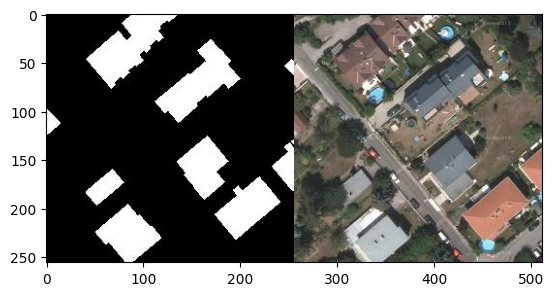

In [11]:
sample_image = tf.io.read_file(TRAIN_PATH + 'vienna36_305.jpeg')
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

plt.figure()
plt.imshow(sample_image)

In [12]:
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image 
    w = tf.shape(image)[1]
    w = w // 2
    real_image = image[:, w:, :]
    input_image = image[:, :w, :]

    # Convert both images to float32 tensors
    real_image = tf.cast(real_image, tf.float32)
    input_image = tf.cast(input_image, tf.float32)

    return real_image, input_image

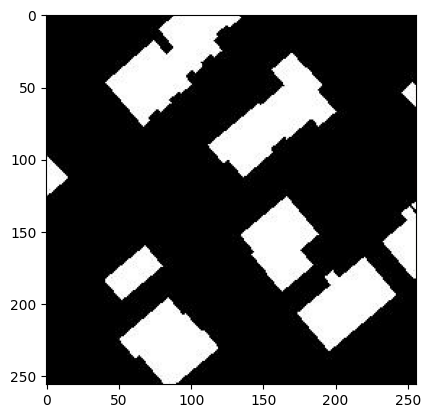

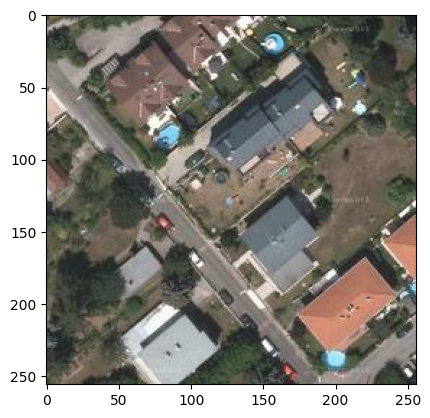

In [13]:
real, input = load(TRAIN_PATH + 'vienna36_305.jpeg')
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(input / 255.0)
plt.figure()
plt.imshow(real / 255.0)

In [14]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(
        input_image,
        [height, width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    real_image = tf.image.resize(
        real_image,
        [height, width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

    return input_image, real_image

In [15]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image,
        size=[2, SPLIT_SIZE_IMAGE, SPLIT_SIZE_IMAGE, 3]
    )

    return cropped_image[0], cropped_image[1]

In [16]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [17]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

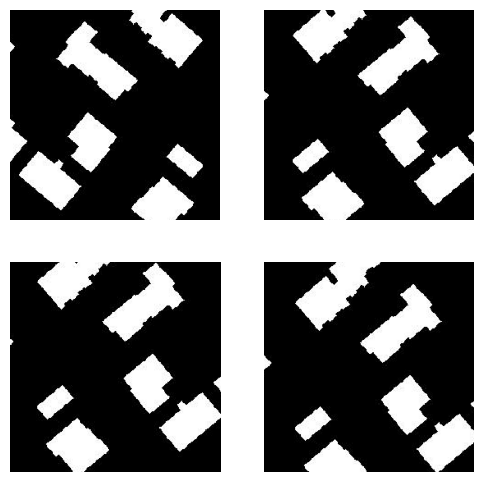

In [18]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(input, real)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

In [19]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image


In [20]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(
        input_image,
        real_image,
        SPLIT_SIZE_IMAGE,
        SPLIT_SIZE_IMAGE
    )
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [21]:
train_dataset = tf.data.Dataset.list_files(TRAIN_PATH + "*.jpeg")
train_dataset = train_dataset.map(
    load_image_train,
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [22]:
test_dataset = tf.data.Dataset.list_files(TEST_PATH + "*.jpeg")
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

Ici je met en place l'encodeur qui fera partie du générateur

In [23]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            size,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False
        )
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(input, 0))
print (down_result.shape)

2023-07-28 23:08:29.112410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


(1, 128, 128, 3)


Ici je met en place le décodeur qui fera partie du générateur

In [24]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False
        )
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


Ici on met en place le generateur de pix2pix

In [25]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[SPLIT_SIZE_IMAGE, SPLIT_SIZE_IMAGE, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS,
        4,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='tanh'
    )  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

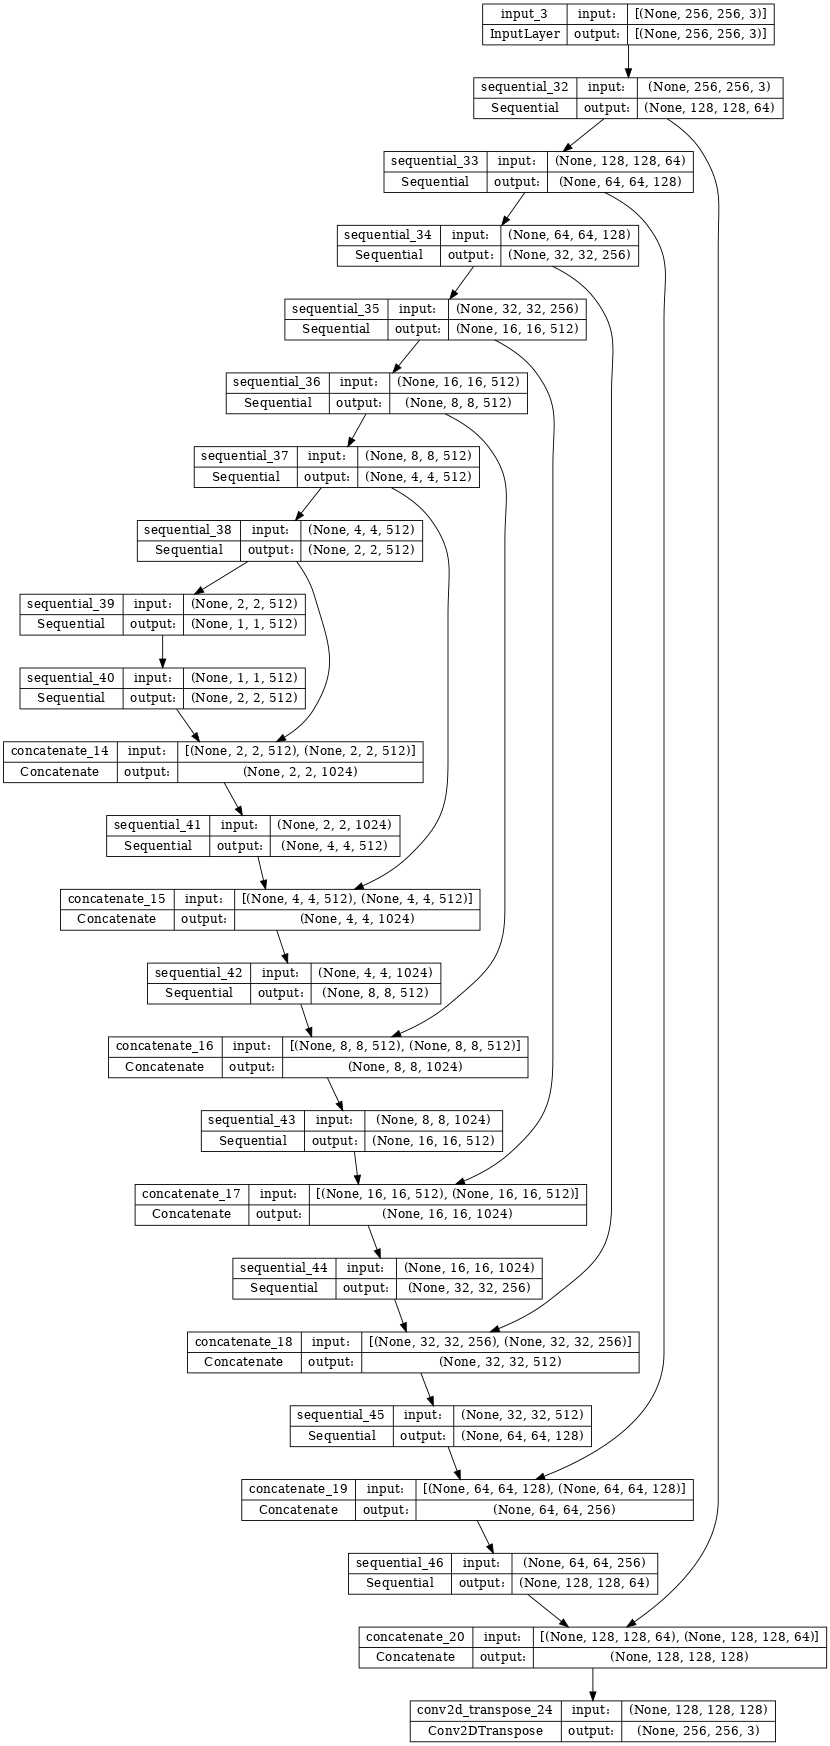

In [28]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


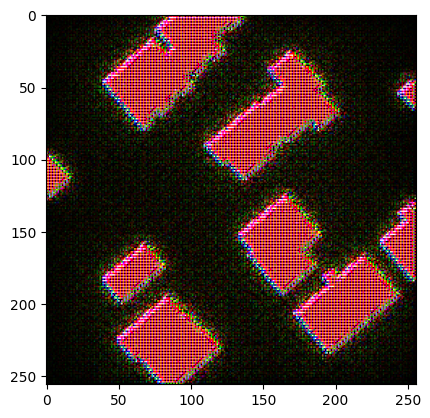

In [30]:
gen_output = generator(input[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [32]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss